# **SMU Course Bidding Prediction Using Deep Neural Networks V1**

<h2><span style="color:red">NOTE: Use at your own discretion.</span></h2>

### **Difference between V1 and V2**
- V1: Using readily available BOSS data found on OASIS.
- V2: Using scraped data from BOSS Bidding website on class and exam timings, locations, and grading basis.

### **Objective**
This notebook predicts the minimum bid required for courses in the SMU bidding system using a **Deep Neural Network (DNN)**. The notebook is structured into several sections for clarity and analysis:

1. **Data Preparation**
    - Loading the data.
    - Stamdardising data types.
    - Splitting data into train and test sets.
2. **Model Development**
    - Baseline model with embeddings for categorical features.
    - Tokenization of text-based features such as `Description` and `Instructor`.
3. **Model Evaluation**
    - Calculating metrics like Mean Squared Log Error (MSLE) and True Positive Rate (TPR).
4. **Safety Factor Analysis**
    - Introducing safety factors for predictions.
5. **Feature Importance**
    - Analyzing the contribution of each feature to the prediction using SHAP.
6. **Hyperparameter tuning**
    - Finding the best model.
7. **Sample prediction**
    - Sample prediction using the best model.
7. **Conclusion**

The columns in the dataset are:
`Term, Description, Section, Vacancy, Min Bid, Instructor, AY, Round, Window, SubjectArea, CatalogueNo, BidderCount`.

---

## **1. Data Preparation**

### **1.1 Loading the Data**
The dataset is loaded and initial checks are performed to inspect data types and missing values.

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import shap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Embedding, Dense, Flatten, Concatenate, Dropout, GlobalAveragePooling1D)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import mean_squared_log_error, accuracy_score

In [2]:
# Load the data
file_path = "transformed_data.csv"  # Ensure this file is in the same directory
raw_data = pd.read_csv(file_path)

# Check data types
print(raw_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36718 entries, 0 to 36717
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Term         36718 non-null  int64  
 1   Description  36718 non-null  object 
 2   Section      36718 non-null  object 
 3   Vacancy      36718 non-null  int64  
 4   Min Bid      36718 non-null  float64
 5   Instructor   36718 non-null  object 
 6   AY           36718 non-null  int64  
 7   Round        31601 non-null  float64
 8   Window       36718 non-null  int64  
 9   SubjectArea  36718 non-null  object 
 10  CatalogueNo  36718 non-null  int64  
 11  BidderCount  36718 non-null  int64  
dtypes: float64(2), int64(6), object(4)
memory usage: 3.4+ MB
None


In [3]:
print(raw_data.head())

   Term                       Description Section  Vacancy  Min Bid  \
0     2  Financial Reporting and Analysis      G3       42    25.00   
1     2                         Valuation      G1       42    10.09   
2     2                         Valuation      G2       42    10.00   
3     2    Auditing for the Public Sector      G1       42    25.00   
4     2          Public Relations Writing      G1       45    10.00   

             Instructor    AY  Round  Window SubjectArea  CatalogueNo  \
0          GOH BENG WEE  2021    6.0       3        ACCT          224   
1        CHENG NAM SANG  2021    6.0       3        ACCT          336   
2        CHENG NAM SANG  2021    6.0       3        ACCT          336   
3          LIM SOO PING  2021    6.0       3        ACCT          409   
4   YASMIN HANNAH RAMLE  2021    6.0       3        COMM          225   

   BidderCount  
0            1  
1            1  
2            2  
3            1  
4            1  



---

### **1.2 Standardizing Data Types**
Categorical features are label-encoded, numerical features are normalized, and text-based features are tokenized and padded for uniform input dimensions.

In [4]:
# Define categorical and numerical features
cat_features = ["Term", "Round", "Section", "Window", "SubjectArea"]
num_features = ["AY", "BidderCount", "Vacancy"]
text_features = ["Description", "Instructor"]
split_features = ["CatalogueNo"]

# Convert categorical features to string (necessary for LabelEncoder)
for col in cat_features:
    raw_data[col] = raw_data[col].astype(str)

# Converting catalogueNo to a string
raw_data["CatalogueNo"] = raw_data["CatalogueNo"].astype(str)

# Encode categorical features
label_encoders = {}

# Update LabelEncoders to include "unknown" for unseen categories
for col in cat_features:
    le = LabelEncoder()
    raw_data[col] = raw_data[col].astype(str)  # Ensure categorical features are strings
    le.fit(raw_data[col])
    # Add "unknown" to the list of classes
    le.classes_ = np.append(le.classes_, "unknown")
    # Encode training data
    raw_data[col] = le.transform(raw_data[col])
    label_encoders[col] = le

# Tokenize and pad textual data (Description)
max_words = 10  # Maximum words for padded sequences
tokenizer_description = Tokenizer()
tokenizer_description.fit_on_texts(raw_data["Description"])
raw_data["Description_seq"] = tokenizer_description.texts_to_sequences(raw_data["Description"])
raw_data["Description_padded"] = pad_sequences(raw_data["Description_seq"], maxlen=max_words, padding='post').tolist()

# Tokenize and pad textual data (Instructor)
max_words_instr = 5  # Instructor names are shorter
tokenizer_instructor = Tokenizer()
tokenizer_instructor.fit_on_texts(raw_data["Instructor"])
raw_data["Instructor_seq"] = tokenizer_instructor.texts_to_sequences(raw_data["Instructor"])
raw_data["Instructor_padded"] = pad_sequences(raw_data["Instructor_seq"], maxlen=max_words_instr, padding='post').tolist()

# Split CatalogueNo into Difficulty and Topic using string operations
raw_data[['CatalogueNo_Difficulty', 'CatalogueNo_Topic']] = raw_data['CatalogueNo'].str.extract(r'(\d)(\d+)', expand=True).fillna(0).astype(int)

# Ensure Term is treated as an integer
raw_data['Term'] = raw_data['Term'].astype(int)


---
### **1.3 Train-Test Split**
Rows with `AY=2024` and `Term=1 or 2` are used as the test set, while the rest form the training set.

In [5]:
# Split the data into train/test sets
test_condition = (raw_data['AY'] == 2024) & (raw_data['Term'].isin([1, 2]))
train_data = raw_data[~test_condition]
test_data = raw_data[test_condition]

In [6]:
# Separate features and target
X_train = train_data[cat_features + num_features + ["Description_padded", "Instructor_padded", "CatalogueNo_Difficulty", "CatalogueNo_Topic"]].copy()
y_train = train_data['Min Bid']
X_test = test_data[cat_features + num_features + ["Description_padded", "Instructor_padded", "CatalogueNo_Difficulty", "CatalogueNo_Topic"]].copy()
y_test = test_data['Min Bid']

# Normalize numerical features
scaler = MinMaxScaler()
X_train[num_features + ["CatalogueNo_Difficulty", "CatalogueNo_Topic"]] = scaler.fit_transform(X_train[num_features + ["CatalogueNo_Difficulty", "CatalogueNo_Topic"]])
X_test[num_features + ["CatalogueNo_Difficulty", "CatalogueNo_Topic"]] = scaler.transform(X_test[num_features + ["CatalogueNo_Difficulty", "CatalogueNo_Topic"]])

# Print final data shapes
print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: (33406, 12)
Test shape: (3312, 12)



---

## **2. Model Development**

### **2.1 Building the Model**
A DNN model is built with embedding layers for categorical features and dense layers for feature interactions.

In [7]:
# Input layers for categorical features and embeddings
embedding_dim = 4  # Dimension of embeddings (can be tuned)
inputs = []
embeddings = []

for col in cat_features:
    input_layer = Input(shape=(1,), name=f"{col}_input")
    emb_layer = Embedding(
        input_dim=len(label_encoders[col].classes_),  # Include "unknown"
        output_dim=embedding_dim
    )(input_layer)
    emb_layer = Flatten()(emb_layer)
    inputs.append(input_layer)
    embeddings.append(emb_layer)

# Input layer for padded description
desc_input = Input(shape=(max_words,), name="description_input")
desc_embedding = Embedding(input_dim=len(tokenizer_description.word_index) + 1, output_dim=8)(desc_input)
desc_flat = GlobalAveragePooling1D()(desc_embedding)
inputs.append(desc_input)
embeddings.append(desc_flat)

# Input layer for padded instructor names
instr_input = Input(shape=(max_words_instr,), name="instructor_input")
instr_embedding = Embedding(input_dim=len(tokenizer_instructor.word_index) + 1, output_dim=8)(instr_input)
instr_flat = GlobalAveragePooling1D()(instr_embedding)
inputs.append(instr_input)
embeddings.append(instr_flat)

# Input layers for CatalogueNo split
diff_input = Input(shape=(1,), name="CatalogueNo_Difficulty")
topic_input = Input(shape=(1,), name="CatalogueNo_Topic")
inputs.extend([diff_input, topic_input])
embeddings.extend([diff_input, topic_input])

# Input layer for numerical features
num_input = Input(shape=(len(num_features),), name="num_input")
inputs.append(num_input)
embeddings.append(num_input)

# Concatenate all inputs
x = Concatenate()(embeddings)

# Dense layers with dropout and regularization
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(1, activation='linear')(x)

# Define the model
model = Model(inputs=inputs, outputs=output)
model.compile(optimizer=Adam(learning_rate=0.001), loss='msle', metrics=['mae'])

# Print model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Term_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
Round_input (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
Section_input (InputLayer)      [(None, 1)]          0                                            
__________________________________________________________________________________________________
Window_input (InputLayer)       [(None, 1)]          0                                            
______________________________________________________________________________________________


---

## **3. Model Evaluation**

### **3.1 Training the Model**
The model is trained using early stopping to prevent overfitting.

In [8]:
# Prepare inputs for the model
X_train_inputs = (
    [X_train[col].to_numpy() for col in cat_features] +  # Categorical inputs
    [np.array(X_train["Description_padded"].tolist()), np.array(X_train["Instructor_padded"].tolist())] +  # Text inputs
    [X_train["CatalogueNo_Difficulty"].to_numpy().reshape(-1, 1),  # Reshape single-column inputs
     X_train["CatalogueNo_Topic"].to_numpy().reshape(-1, 1),
     X_train[num_features].to_numpy()]  # Numerical inputs
)

X_test_inputs = (
    [X_test[col].to_numpy() for col in cat_features] +
    [np.array(X_test["Description_padded"].tolist()), np.array(X_test["Instructor_padded"].tolist())] +
    [X_test["CatalogueNo_Difficulty"].to_numpy().reshape(-1, 1),
     X_test["CatalogueNo_Topic"].to_numpy().reshape(-1, 1),
     X_test[num_features].to_numpy()]
)

In [9]:
# Add EarlyStopping to prevent overfitting
early_stopping = EarlyStopping(patience=10, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train_inputs, y_train,
    validation_data=(X_test_inputs, y_test),
    epochs=100, batch_size=32,
    callbacks=[early_stopping])

Epoch 1/100
1044/1044 [==============================] - 2s 1ms/step - loss: 0.6023 - mae: 12.4749 - val_loss: 0.3725 - val_mae: 14.4108
Epoch 2/100
1044/1044 [==============================] - 1s 1ms/step - loss: 0.2746 - mae: 10.8804 - val_loss: 0.3516 - val_mae: 13.9431
Epoch 3/100
1044/1044 [==============================] - 1s 1ms/step - loss: 0.2553 - mae: 10.4530 - val_loss: 0.3441 - val_mae: 13.7300
Epoch 4/100
1044/1044 [==============================] - 1s 1ms/step - loss: 0.2433 - mae: 10.1055 - val_loss: 0.3319 - val_mae: 13.4384
Epoch 5/100
1044/1044 [==============================] - 1s 1ms/step - loss: 0.2343 - mae: 9.8738 - val_loss: 0.3279 - val_mae: 13.2772
Epoch 6/100
1044/1044 [==============================] - 1s 1ms/step - loss: 0.2274 - mae: 9.6985 - val_loss: 0.3291 - val_mae: 13.2119
Epoch 7/100
1044/1044 [==============================] - 1s 1ms/step - loss: 0.2215 - mae: 9.5472 - val_loss: 0.3272 - val_mae: 13.1416
Epoch 8/100
1044/1044 [=====================


---

### **3.2 Metrics**
Metrics like MSLE and TPR are calculated to evaluate model performance.

In [10]:
# Predict on the test set
y_pred = model.predict(X_test_inputs)

# Calculate MSLE
msle = mean_squared_log_error(y_test, y_pred)
print(f"MSLE: {msle:.4f}")

# Custom Accuracy (TPR)
TPR = np.mean(y_pred.flatten() >= y_test)
print(f"TPR Accuracy: {TPR:.2%}")

MSLE: 0.3170
TPR Accuracy: 55.19%


In [15]:
y_pred = y_pred.flatten()

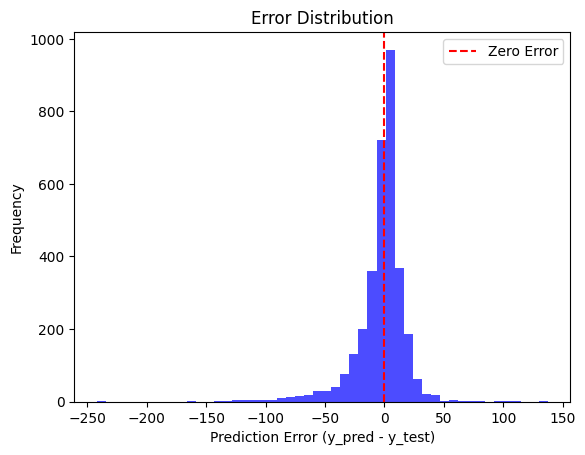

Mean Error: -2.962502200937502
Median Error: 0.8905782699584961
Fraction of Predictions Below Actual: 44.81%


In [16]:
errors = y_pred - y_test

plt.hist(errors, bins=50, alpha=0.7, color='blue')
plt.axvline(0, color='red', linestyle='--', label='Zero Error')
plt.xlabel('Prediction Error (y_pred - y_test)')
plt.ylabel('Frequency')
plt.title('Error Distribution')
plt.legend()
plt.show()

mean_error = np.mean(errors)
median_error = np.median(errors)
below_zero = np.mean(errors < 0)  # Fraction of under-predictions
print(f"Mean Error: {mean_error}")
print(f"Median Error: {median_error}")
print(f"Fraction of Predictions Below Actual: {below_zero:.2%}")


---

## **4. Safety Factor Analysis**
Safety factors are applied to ensure predictions exceed actual bids with a margin.

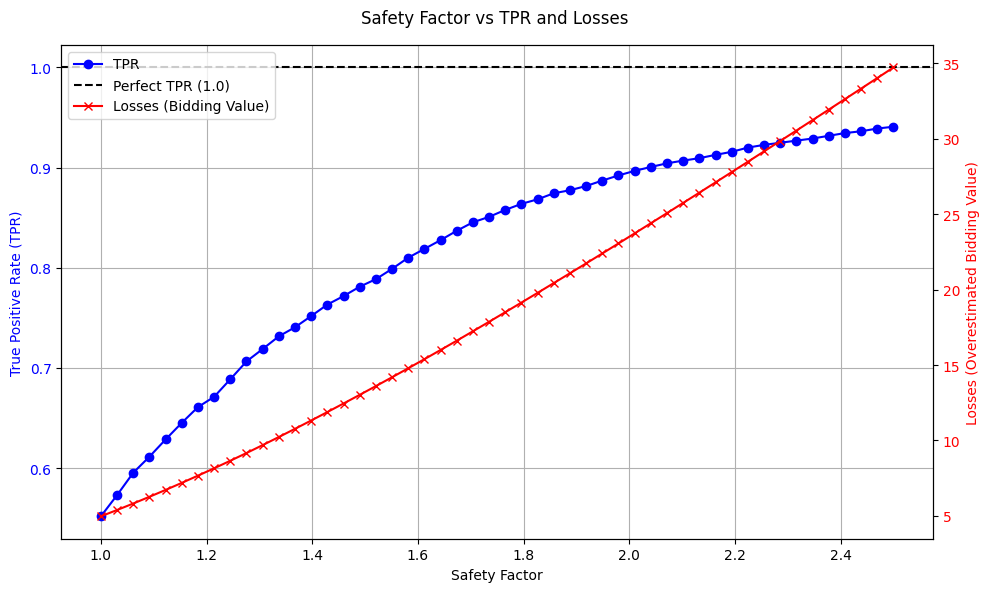

In [17]:
# Define a range of safety factors to evaluate
safety_factors = np.linspace(1.0, 2.5, 50)  # From 1.0 (no margin) to 2.5 (150% margin)

# Calculate TPR and Losses for each safety factor
tpr_values = []
loss_values = []
for sf in safety_factors:
    # True Positive Rate (TPR)
    tpr = np.mean((y_pred * sf) >= y_test)
    
    # Losses: Over-predictions where y_pred * sf > y_test
    losses = np.mean(np.maximum((y_pred * sf) - y_test, 0))  # Sum of over-predicted bid values
    
    tpr_values.append(tpr)
    loss_values.append(losses)

# Create a dual-axis plot
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot TPR
ax1.plot(safety_factors, tpr_values, marker='o', color='blue', label='TPR')
ax1.set_xlabel('Safety Factor')
ax1.set_ylabel('True Positive Rate (TPR)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.axhline(1.0, color='black', linestyle='--', label='Perfect TPR (1.0)')

# Create a second y-axis for Losses
ax2 = ax1.twinx()
ax2.plot(safety_factors, loss_values, marker='x', color='red', label='Losses (Bidding Value)')
ax2.set_ylabel('Losses (Overestimated Bidding Value)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Add grid, legend, and title
ax1.grid(True)
fig.suptitle('Safety Factor vs TPR and Losses')
fig.tight_layout()

# Add legends for both axes
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

plt.show()


In [18]:
# Normalize losses for comparison with TPR
max_loss = max(loss_values)
lambda_weight = 0.5  # Adjust this weight based on importance of losses vs TPR

# Calculate the combined score
combined_scores = [
    tpr - lambda_weight * (loss / max_loss) for tpr, loss in zip(tpr_values, loss_values)
]

In [19]:
# Find the optimal safety factor
optimal_index = np.argmax(combined_scores)
optimal_safety_factor = safety_factors[optimal_index]

# Print results
print(f"Optimal Safety Factor: {optimal_safety_factor:.2f}")
print(f"TPR at Optimal Factor: {tpr_values[optimal_index]:.2%}")
print(f"Loss at Optimal Factor: {loss_values[optimal_index]:.2f}")

Optimal Safety Factor: 1.67
TPR at Optimal Factor: 83.70%
Loss at Optimal Factor: 16.61


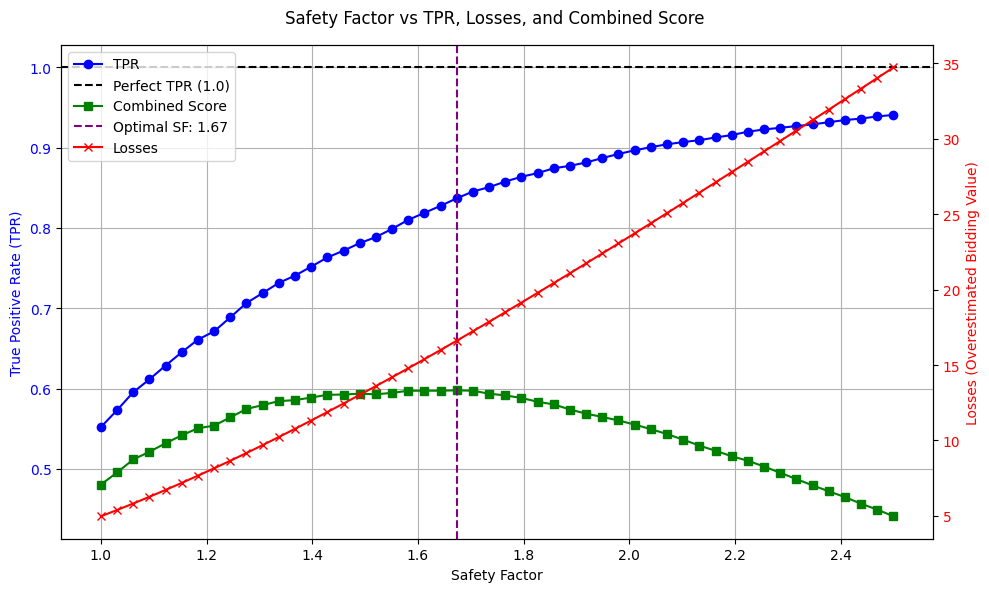

In [20]:
# Plot TPR, Losses, and Combined Score
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot TPR
ax1.plot(safety_factors, tpr_values, marker='o', color='blue', label='TPR')
ax1.set_xlabel('Safety Factor')
ax1.set_ylabel('True Positive Rate (TPR)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.axhline(1.0, color='black', linestyle='--', label='Perfect TPR (1.0)')

# Create a second y-axis for Losses
ax2 = ax1.twinx()
ax2.plot(safety_factors, loss_values, marker='x', color='red', label='Losses')
ax2.set_ylabel('Losses (Overestimated Bidding Value)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Plot Combined Score
ax1.plot(safety_factors, combined_scores, marker='s', color='green', label='Combined Score')

# Add optimal point
ax1.axvline(optimal_safety_factor, color='purple', linestyle='--', label=f'Optimal SF: {optimal_safety_factor:.2f}')

# Add grid, legend, and title
ax1.grid(True)
fig.suptitle('Safety Factor vs TPR, Losses, and Combined Score')
fig.tight_layout()

# Add legends for both axes
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

plt.show()


---

## **5. Feature Importance**
SHAP is used to analyze feature importance.

In [21]:
# Concatenate all input arrays into a single 2D NumPy array
X_train_inputs_combined = np.hstack(
    [X_train[col].to_numpy().reshape(-1, 1) for col in cat_features] +  # Categorical inputs reshaped
    [np.array(X_train["Description_padded"].tolist()),  # Description padded sequences
     np.array(X_train["Instructor_padded"].tolist()),  # Instructor padded sequences
     X_train["CatalogueNo_Difficulty"].to_numpy().reshape(-1, 1),  # Reshaped CatalogueNo_Difficulty
     X_train["CatalogueNo_Topic"].to_numpy().reshape(-1, 1),  # Reshaped CatalogueNo_Topic
     X_train[num_features].to_numpy()]  # Numerical inputs
)

In [22]:
# Combine test inputs into a single 2D array
X_test_inputs_combined = np.hstack(
    [X_test[col].to_numpy().reshape(-1, 1) for col in cat_features] +  # Categorical inputs reshaped
    [np.array(X_test["Description_padded"].tolist()),  # Description padded sequences
     np.array(X_test["Instructor_padded"].tolist()),  # Instructor padded sequences
     X_test["CatalogueNo_Difficulty"].to_numpy().reshape(-1, 1),  # Reshaped CatalogueNo_Difficulty
     X_test["CatalogueNo_Topic"].to_numpy().reshape(-1, 1),  # Reshaped CatalogueNo_Topic
     X_test[num_features].to_numpy()]  # Numerical inputs
)

In [23]:
def model_predict(inputs):
    """
    Wrapper for the model's predict function to split the single input array
    into the expected list of inputs for the model.
    """
    # Split inputs based on the number of features per input group
    split_inputs = (
        [inputs[:, i].reshape(-1, 1) for i in range(len(cat_features))] +  # Categorical inputs
        [inputs[:, len(cat_features):len(cat_features) + max_words],  # Description
         inputs[:, len(cat_features) + max_words:len(cat_features) + max_words + max_words_instr],  # Instructor
         inputs[:, len(cat_features) + max_words + max_words_instr].reshape(-1, 1),  # CatalogueNo_Difficulty
         inputs[:, len(cat_features) + max_words + max_words_instr + 1].reshape(-1, 1),  # CatalogueNo_Topic
         inputs[:, len(cat_features) + max_words + max_words_instr + 2:]]  # Numerical features
    )
    return model.predict(split_inputs)

In [24]:
# Sample 100 rows from the background data
background_data = shap.sample(X_train_inputs_combined, 100)

In [25]:
# Use the sampled background data to create the explainer
explainer = shap.KernelExplainer(model_predict, background_data)

In [26]:
# Use only 100 test samples for explanation
X_test_inputs_combined_subset = X_test_inputs_combined[:100]

# Calculate SHAP values
shap_values = explainer.shap_values(X_test_inputs_combined_subset, nsamples=50)

  0%|          | 0/100 [00:00<?, ?it/s]

Regressors in active set degenerate. Dropping a regressor, after 13 iterations, i.e. alpha=5.034e-02, with an active set of 13 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 16 iterations, i.e. alpha=3.133e-02, with an active set of 14 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 24 iterations, alpha=8.460e-03, previous alpha=7.965e-03, with an active set of 21 regressors.
Regressors in active set degenerate. Dropping a regressor, after 23 iterations, i.e. alpha=1.299e-03, with an active set of 21 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 25 

In [27]:
# Combine inputs programmatically and map features to columns
combined_feature_names = (
    [f"{col}_input" for col in cat_features] +  # Categorical features
    [f"Description_{i}" for i in range(max_words)] +  # Description padding columns
    [f"Instructor_{i}" for i in range(max_words_instr)] +  # Instructor padding columns
    ["CatalogueNo_Difficulty", "CatalogueNo_Topic"] +  # Split features
    num_features  # Numerical features
)

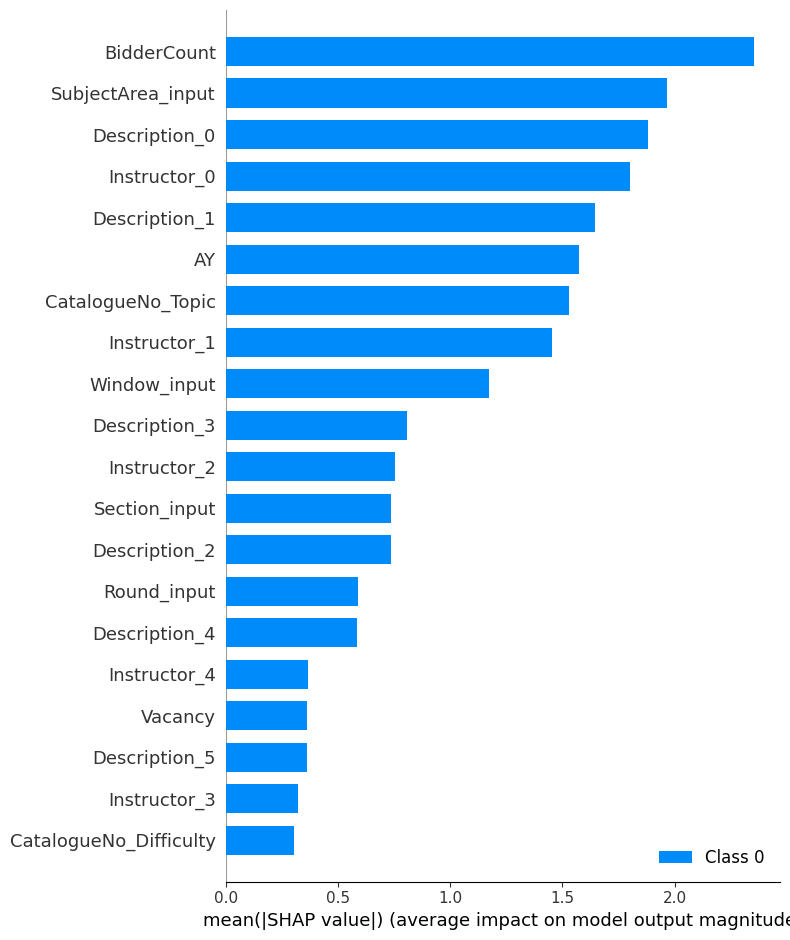

In [28]:
# Generate SHAP summary plot with validated feature names
shap.summary_plot(
    shap_values,
    X_test_inputs_combined_subset,
    feature_names=combined_feature_names  # Use the validated feature names
)


---

## **6. Hyperparameter tuning**
Hyperparameter tuning using keras tuner

### **Keras Tuner**

In [29]:
import keras_tuner as kt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dense, Dropout, Concatenate, Flatten

def build_model(hp):
    # Define input layers
    inputs = []
    embeddings = []
    for col in cat_features:
        input_layer = Input(shape=(1,), name=f"{col}_input")
        emb_layer = Embedding(input_dim=raw_data[col].nunique() + 1, output_dim=hp.Int('embedding_dim', 4, 16, step=4))(input_layer)
        emb_layer = Flatten()(emb_layer)
        inputs.append(input_layer)
        embeddings.append(emb_layer)

    # Description input
    desc_input = Input(shape=(max_words,), name="description_input")
    desc_embedding = Embedding(input_dim=len(tokenizer_description.word_index) + 1, output_dim=hp.Int('desc_emb_dim', 8, 16, step=4))(desc_input)
    desc_flat = Flatten()(desc_embedding)
    inputs.append(desc_input)
    embeddings.append(desc_flat)

    # Instructor input
    instr_input = Input(shape=(max_words_instr,), name="instructor_input")
    instr_embedding = Embedding(input_dim=len(tokenizer_instructor.word_index) + 1, output_dim=hp.Int('instr_emb_dim', 8, 16, step=4))(instr_input)
    instr_flat = Flatten()(instr_embedding)
    inputs.append(instr_input)
    embeddings.append(instr_flat)

    # Add other inputs (numerical and split features)
    diff_input = Input(shape=(1,), name="CatalogueNo_Difficulty")
    topic_input = Input(shape=(1,), name="CatalogueNo_Topic")
    num_input = Input(shape=(len(num_features),), name="num_input")
    inputs.extend([diff_input, topic_input, num_input])
    embeddings.extend([diff_input, topic_input, num_input])

    # Concatenate all embeddings
    x = Concatenate()(embeddings)

    # Add tunable dense layers
    for i in range(hp.Int('num_layers', 1, 3)):
        x = Dense(hp.Int(f'units_{i}', min_value=64, max_value=128, step=32), activation='relu')(x)
        x = Dropout(hp.Float(f'dropout_{i}', min_value=0.2, max_value=0.5, step=0.1))(x)

    output = Dense(1, activation='linear')(x)

    # Compile model
    model = Model(inputs=inputs, outputs=output)
    model.compile(
        optimizer=hp.Choice('optimizer', ['adam', 'sgd']),
        loss='msle',
        metrics=['mae']  # Include TPR as a metric
    )
    return model

In [30]:
# Define the tuner
tuner = kt.RandomSearch(
    build_model,
    objective=kt.Objective("val_loss", direction="min"),  # Optimise for TPR
    max_trials=10,  # Number of hyperparameter combinations to try
    executions_per_trial=2,  # Average results over 2 runs for stability
    directory='kt_search_dir',
    project_name='course_bid_tuning'
)

Reloading Tuner from kt_search_dir\course_bid_tuning\tuner0.json


In [31]:
# Run the tuner
tuner.search(
    X_train_inputs, y_train,
    validation_data=(X_test_inputs, y_test),
    epochs=50,
    batch_size=32,
)

In [32]:
# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters()[0]

# Build the best model with optimal hyperparameters
best_model = tuner.hypermodel.build(best_hps)

# Apply EarlyStopping on validation loss
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the best model on the full dataset
history = best_model.fit(
    X_train_inputs, y_train,
    validation_data=(X_test_inputs, y_test),
    epochs=1000,
    batch_size=32,
    callbacks=[early_stopping]
)

Epoch 1/1000
1044/1044 [==============================] - 2s 2ms/step - loss: 0.4624 - mae: 11.8639 - val_loss: 0.3546 - val_mae: 13.9182
Epoch 2/1000
1044/1044 [==============================] - 2s 2ms/step - loss: 0.2567 - mae: 10.3465 - val_loss: 0.3454 - val_mae: 13.5588
Epoch 3/1000
1044/1044 [==============================] - 2s 2ms/step - loss: 0.2403 - mae: 9.9371 - val_loss: 0.3454 - val_mae: 13.5033
Epoch 4/1000
1044/1044 [==============================] - 2s 2ms/step - loss: 0.2237 - mae: 9.5619 - val_loss: 0.3299 - val_mae: 13.0895
Epoch 5/1000
1044/1044 [==============================] - 2s 2ms/step - loss: 0.2127 - mae: 9.3239 - val_loss: 0.3249 - val_mae: 12.9215
Epoch 6/1000
1044/1044 [==============================] - 2s 1ms/step - loss: 0.2047 - mae: 9.1273 - val_loss: 0.3256 - val_mae: 12.9971
Epoch 7/1000
1044/1044 [==============================] - 1s 1ms/step - loss: 0.1974 - mae: 8.9420 - val_loss: 0.3283 - val_mae: 13.1716
Epoch 8/1000
1044/1044 [===============

In [33]:
# Manually calculate TPR if needed
y_pred = best_model.predict(X_test_inputs).flatten()
TPR_manual = np.mean(y_pred >= y_test)
print(f"Manual TPR Accuracy: {TPR_manual:.2%}")

Manual TPR Accuracy: 58.12%


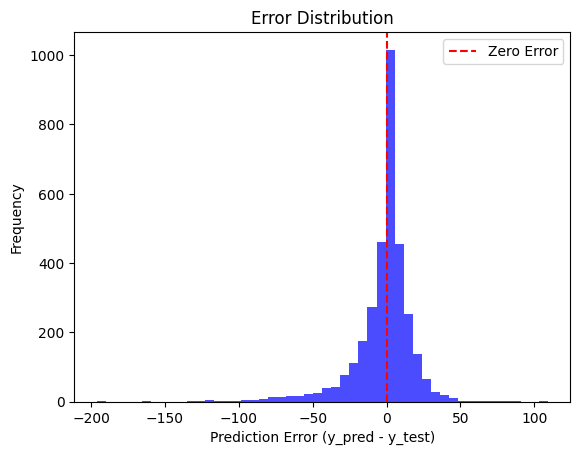

Mean Error: -2.0996100204002457
Median Error: 1.5606451034545898
Fraction of Predictions Below Actual: 41.88%


In [38]:
errors = y_pred - y_test

plt.hist(errors, bins=50, alpha=0.7, color='blue')
plt.axvline(0, color='red', linestyle='--', label='Zero Error')
plt.xlabel('Prediction Error (y_pred - y_test)')
plt.ylabel('Frequency')
plt.title('Error Distribution')
plt.legend()
plt.show()

mean_error = np.mean(errors)
median_error = np.median(errors)
below_zero = np.mean(errors < 0)  # Fraction of under-predictions
print(f"Mean Error: {mean_error}")
print(f"Median Error: {median_error}")
print(f"Fraction of Predictions Below Actual: {below_zero:.2%}")


---

## **7. Sample prediction**
Sample prediction using tuned model

In [35]:
# Sample new data
new_data = pd.DataFrame({
    'Term': [1],
    'Description': ["Financial Analytics"],
    'Section': ["G1"],
    'Vacancy': [45],
    'Instructor': ["RANDALL EUGENE DURAN"],
    'AY': [2024],
    'Round': [1],
    'Window': [1],
    'SubjectArea': ["IS"],
    'CatalogueNo': ["453"],
    'BidderCount': [35]
})


In [36]:
def transform_new_data(new_data, cat_features, num_features, label_encoders, tokenizer_description, tokenizer_instructor, scaler):
    """
    Transforms new data to align with the preprocessing pipeline used for training.
    
    Args:
        new_data (pd.DataFrame): New data to be transformed.
        cat_features (list): List of categorical feature names.
        num_features (list): List of numerical feature names.
        label_encoders (dict): Dictionary of trained LabelEncoders for categorical features.
        tokenizer_description (Tokenizer): Trained tokenizer for the Description feature.
        tokenizer_instructor (Tokenizer): Trained tokenizer for the Instructor feature.
        scaler (MinMaxScaler): Trained scaler for numerical features.
    
    Returns:
        Transformed inputs ready for the model.
    """
    # Step 1: Convert categorical features to string
    for col in cat_features:
        new_data[col] = new_data[col].astype(str)

    # Map new data to existing mappings, assigning unseen categories to "unknown"
    for col in cat_features:
        le = label_encoders[col]
        unseen_mask = ~new_data[col].isin(le.classes_)
        new_data.loc[unseen_mask, col] = "unknown"  # Assign unseen categories to "unknown"
        new_data[col] = le.transform(new_data[col])

    # Step 3: Tokenize and pad textual data (Description)
    new_data["Description_seq"] = tokenizer_description.texts_to_sequences(new_data["Description"])
    new_data["Description_padded"] = pad_sequences(new_data["Description_seq"], maxlen=10, padding='post').tolist()

    # Step 4: Tokenize and pad textual data (Instructor)
    new_data["Instructor_seq"] = tokenizer_instructor.texts_to_sequences(new_data["Instructor"])
    new_data["Instructor_padded"] = pad_sequences(new_data["Instructor_seq"], maxlen=5, padding='post').tolist()

    # Step 5: Split CatalogueNo into Difficulty and Topic
    new_data[['CatalogueNo_Difficulty', 'CatalogueNo_Topic']] = new_data['CatalogueNo'].astype(str).str.extract(r'(\d)(\d+)', expand=True).fillna(0).astype(int)

    # Step 6: Normalize numerical features
    new_data[num_features + ["CatalogueNo_Difficulty", "CatalogueNo_Topic"]] = scaler.transform(
        new_data[num_features + ["CatalogueNo_Difficulty", "CatalogueNo_Topic"]]
    )

    # Step 7: Prepare inputs for the model
    inputs = (
        [new_data[col].to_numpy().reshape(-1, 1) for col in cat_features] +  # Categorical inputs
        [np.array(new_data["Description_padded"].tolist()),  # Description sequences
         np.array(new_data["Instructor_padded"].tolist())] +  # Instructor sequences
        [new_data["CatalogueNo_Difficulty"].to_numpy().reshape(-1, 1),  # Difficulty
         new_data["CatalogueNo_Topic"].to_numpy().reshape(-1, 1),       # Topic
         new_data[num_features].to_numpy()]                            # Numerical features
    )
    
    return inputs

In [37]:
# Define categorical and numerical features
cat_features = ["Term", "Round", "Section", "Window", "SubjectArea"]
num_features = ["AY", "BidderCount", "Vacancy"]

# Transform new data
new_data_inputs = transform_new_data(
    new_data=new_data,
    cat_features=cat_features,
    num_features=num_features,
    label_encoders=label_encoders,
    tokenizer_description=tokenizer_description,
    tokenizer_instructor=tokenizer_instructor,
    scaler=scaler
)

# Predict the Min Bid
new_data_pred = best_model.predict(new_data_inputs).flatten() * 1.67
print(f"Predicted Min Bid: {new_data_pred[0]:.2f}")

Predicted Min Bid: 33.97


---

## **8. Conclusion**

### **What Was Done**
- Built a DNN model with embeddings for categorical and text features.
- Evaluated the model using MSLE and TPR.
- Conducted feature importance and safety factor analysis.

### **What Can Be Concluded**
- **Top Features**: Instructor, description, and round were most influential. However, BidderCount was more influential for DNN.
- **Performance**: Compared to the performance of boosting, the model performed slightly worse. This is interesting as while researching for which models to use to develop the prediction model, many said that neural networks were better for unstructured data whereas boosting is better for structured tabular data. Now I can say from firsthand experience that this is true.

### **What To Do Next**
- Explore additional features from Boss bidding such as class and exam timings, location, and grading basis.
- Collect more data, e.g., individual bid amounts, to improve predictions.